## Hospital Length of stay using LightGBM Model and Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
#from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients.DEATHDATE.fillna("2021-01-01", inplace = True) 
patients.DEATHDATE = pd.to_datetime(patients["DEATHDATE"])
patients.BIRTHDATE =  pd.to_datetime(patients["BIRTHDATE"])
patients["age"] =patients.DEATHDATE- patients.BIRTHDATE
patients['age'] = patients.age.astype('timedelta64[Y]').astype('int')
patients["healthcare_coverage_ratio"] = patients.HEALTHCARE_COVERAGE / patients.HEALTHCARE_EXPENSES
patients = patients[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
patients = patients.rename(columns = {"Id": "patient"})

In [6]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    data = data.rename(columns = {"Id": "patient"})
    return data

In [7]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [8]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [9]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [10]:

careplan_df = pd.merge(careplan_df, patients,  on='patient', how = "left")

careplan_df_test = pd.merge(careplan_df_test, patients_test,  on='patient', how = "left")

In [11]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [12]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [13]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [14]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [15]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [16]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [17]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [18]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [19]:
observations_df.head()

,patient,patient's_observation_of_Body_Weight,patient's_observation_of_Respiratory_rate,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Heart_rate,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Body_temperature,patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,patient's_observation_of_MCV_Entitic_volume_by_Automated_count,...,patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count,patient's_observation_of_Lymphocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count,patient's_observation_of_Monocytes100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Erythrocyte_distribution_width_Ratio_by_Automated_count,patient's_observation_of_Glucose_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Eosinophils100_leukocytes_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
6759119,c58c2300-e706-4904-b0d8-fa71e7ce3e5c,0,0,0,0,0,0,0,0,0,...,168.8,0,0,0,0,0,0,Chloride,2,2
9144340,c7ed301a-c24e-47ac-9f50-55edcf3778ad,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Body_Weight,2,2
1658703,a9c55185-4e51-4fe3-ac49-9f842420d8e8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Calcium_Massvolume_in_Serum_or_Plasma,1,1
6457767,ef1990b0-f3e1-4711-b8f6-92d767bb50b0,0,0,0,0,0,122.0,0,0,0,...,0,0,0,0,0,0,0,Systolic_Blood_Pressure,1,1
12337919,4a570f56-af75-473d-b171-51c18cc9819c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Carbon_dioxide_Partial_pressure_in_Arterial_blood,3,3


In [20]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [21]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [22]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [23]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [24]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [25]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [26]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [27]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [28]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [29]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [30]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [31]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [32]:
def merger(data1, data2, data3, data4,data5, data6, data7, data8, join_keys, goal):
    merged_df = pd.merge(data1, data2, on = join_keys)
    merged_df = pd.merge(merged_df, data3, on = join_keys)
    merged_df = pd.merge(merged_df, data4, on = join_keys)
    return merged_df
    

In [33]:
merged_train= pd.merge(careplan_df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")


In [34]:
merged_train.columns

Index(['patient', 'careplan_start', 'careplan_end', 'careplan_desc',
       'careplan_reason', 'Infectious disease care plan record artifact',
       'Diabetes self management plan',
       'Lifestyle education regarding hypertension',
       'Self-care interventions procedure', 'Respiratory therapy',
       ...
       'patient's_alergy_of_Allergy to grass pollen',
       'patient's_alergy_of_Allergy to tree pollen',
       'patient's_alergy_of_House dust mite allergy',
       'patient's_alergy_of_Shellfish allergy',
       'patient's_alergy_of_Allergy to bee venom',
       'patient's_alergy_of_Allergy to peanuts',
       'patient's_alergy_of_Allergy to fish',
       'patient's_alergy_of_Allergy to nut', 'patient's most seen allergy',
       'doctor_count_per_city'],
      dtype='object', length=172)

In [35]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8215 entries, 0 to 8214
Columns: 172 entries, patient to doctor_count_per_city
dtypes: float64(111), int64(7), object(54)
memory usage: 10.8+ MB


In [36]:
merged_test= pd.merge(careplan_df_test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")


In [37]:
#merged_test= pd.merge(careplan_df, conditions_df, on = ["patient"])
#merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])

In [38]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "total_med_duration_of_patient"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "total_med_duration_of_patient"]).reset_index(drop = True)

In [39]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True)

In [40]:
## let's convert our date objects into datetime objects for further usage

data.careplan_end = pd.to_datetime(data.careplan_end)
data.careplan_start = pd.to_datetime(data.careplan_start)

In [41]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 2475 unique patients.


In [42]:
data.fillna(0, inplace = True)

In [43]:
data = data.drop([ "careplan_desc", "careplan_reason"], 1)

In [44]:
data.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,2020-03-01,2020-03-30 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,7885b552-ad7a-44b9-b63b-e9e8274e38e2,2020-02-27,2020-03-25 00:00:00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,1b9abba6-fc17-4af5-8459-ce2cfdffab16,2020-03-08,2020-04-01 00:00:00,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Shellfish allergy,0.0
3,4efc24fe-f60b-4fd0-81fe-65cb34b3e68e,2020-03-10,2020-04-08 00:00:00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,ba49baff-773e-4ba5-8fa4-081d1642280f,2020-03-05,2020-03-28 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [45]:
df = data.copy()
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,2020-03-01,2020-03-30 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,7885b552-ad7a-44b9-b63b-e9e8274e38e2,2020-02-27,2020-03-25 00:00:00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,1b9abba6-fc17-4af5-8459-ce2cfdffab16,2020-03-08,2020-04-01 00:00:00,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Shellfish allergy,0.0
3,4efc24fe-f60b-4fd0-81fe-65cb34b3e68e,2020-03-10,2020-04-08 00:00:00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,ba49baff-773e-4ba5-8fa4-081d1642280f,2020-03-05,2020-03-28 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


### Let's create our target feature, careplan duration


In [46]:
df = df.sort_values("careplan_start")
df.careplan_end = pd.to_datetime(df.careplan_end, format='%Y-%m-%d', errors='coerce')
df.careplan_start = pd.to_datetime(df.careplan_start, format='%Y-%m-%d', errors='coerce')
df["careplan_duration"] = (df.careplan_end - df.careplan_start).dt.days
df = df.reset_index(drop = True)
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,careplan_duration
0,19c07c31-a791-42e3-bd13-876d8a36af33,2020-01-24,2020-02-20,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,27.0
1,0d38471f-d675-4957-8413-603b34f9f207,2020-01-26,2020-02-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,34.0
2,85b47fec-6b58-4d23-acfc-274581055525,2020-01-31,2020-02-20,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,20.0
3,1a7bb906-1c86-416a-aeb2-58a5e243824a,2020-02-01,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,26.0
4,22ecf2f5-acf6-4276-b2a8-b96e6cb12b0d,2020-02-02,2020-03-09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,36.0


In [47]:
#Create time features

df["start_month"] = df.careplan_start.dt.month
df["start_day"] = df.careplan_start.dt.day_of_year
df["start_week"] = df.careplan_start.dt.day_of_week
df["start_year"] = df.careplan_start.dt.year

In [48]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [49]:
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,careplan_duration,start_month,start_day,start_week,start_year
0,19c07c31-a791-42e3-bd13-876d8a36af33,2020-01-24,2020-02-20,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0,0.0,27.0,1,24,4,2020
1,0d38471f-d675-4957-8413-603b34f9f207,2020-01-26,2020-02-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,34.0,1,26,6,2020
2,85b47fec-6b58-4d23-acfc-274581055525,2020-01-31,2020-02-20,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,2.0,20.0,1,31,4,2020
3,1a7bb906-1c86-416a-aeb2-58a5e243824a,2020-02-01,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,26.0,2,32,5,2020
4,22ecf2f5-acf6-4276-b2a8-b96e6cb12b0d,2020-02-02,2020-03-09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1.0,36.0,2,33,6,2020


In [50]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [51]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### LightGBM

In [54]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")

In [55]:
train = df.loc[(df.dataset == "train") & (df.careplan_duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())]

In [56]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### Train & Validation 

In [57]:
from sklearn.model_selection import train_test_split
X = train.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)
y = train.careplan_duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)


In [58]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

2.979828598909138

In [59]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1))
lgb_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_mae = mae(test.careplan_duration, real_preds)
lgb_r2 = r2_score(test.careplan_duration, real_preds)



In [60]:
lgb_rmse

2.502464583952674

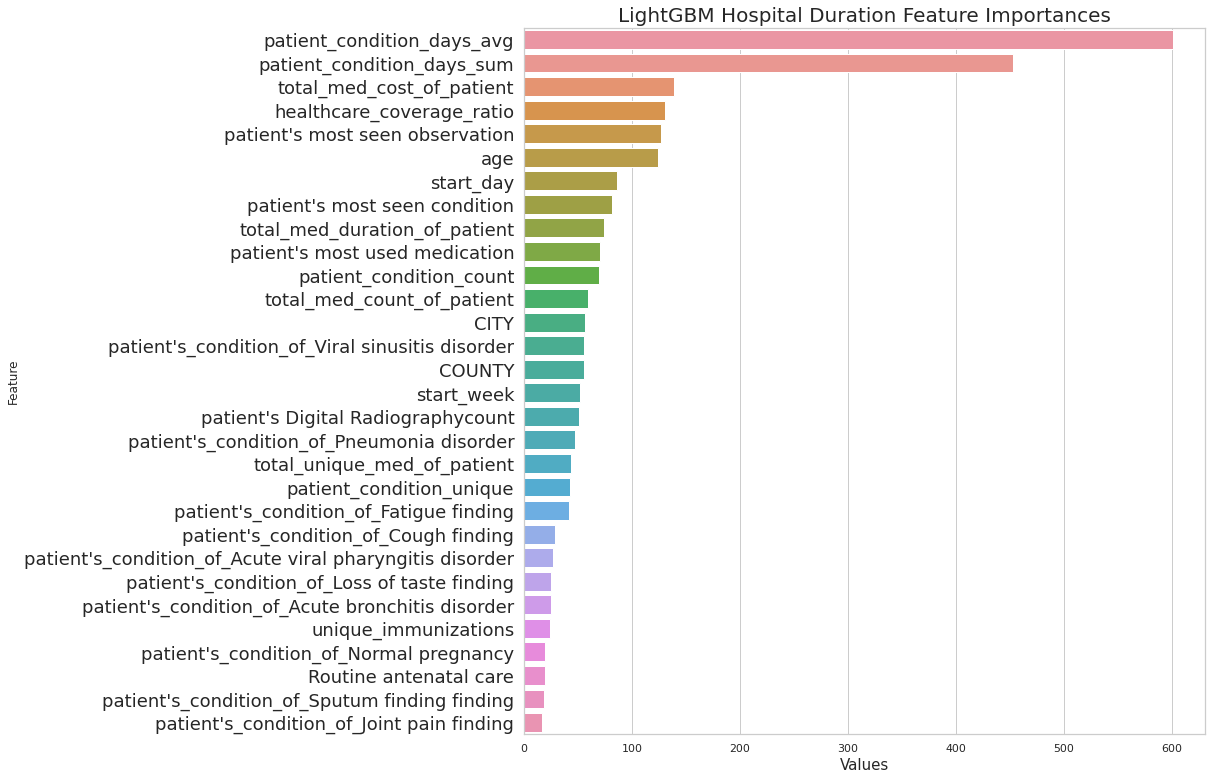

<Figure size 432x288 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:30])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM Hospital Duration Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [62]:
top30_features = feature_imp.sort_values("Value", ascending = False)[:20].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top30_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [63]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [64]:
X = train.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)[FEATURES]
y = train.careplan_duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

3.060534711844031

In [65]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start",
                                      "careplan_end", "patient"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_mae = mae(test.careplan_duration, real_preds)
lgb_r2 = r2_score(test.careplan_duration, real_preds)


lgb_rmse

2.4991701121273326

### Parameter Optimization

In [66]:
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }

In [67]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fad0f7bbdd0>,
                   estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.99],
                                        'max_depth': [3, 4, 5, 6, 7, 10],
                                        'min_child_weight': [1, 5, 10, 15],
                                        'num_iterations': [100, 500, 1000],
                                        'num_leaves': [4, 8, 16, 32, 64, 80],
                                        'reg_lambda': [0.2, 0.5, 1, 1.5]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [68]:
print(random_search.best_params_)

{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}


In [69]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Tuned LGBM Validation RMSE is ", val_result2)

Tuned LGBM Validation RMSE is  3.048960952143066


##Test

In [70]:
model.fit(X, y)

real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.careplan_duration, real_preds)
lgb_tuned_r2 = r2_score(test.careplan_duration, real_preds)
print("Tuned LGBM Test RMSE is ", lgb_tuned_rmse)

Tuned LGBM Test RMSE is  2.4695264473799767


Text(0, 0.5, '% difference between real values and predictions')

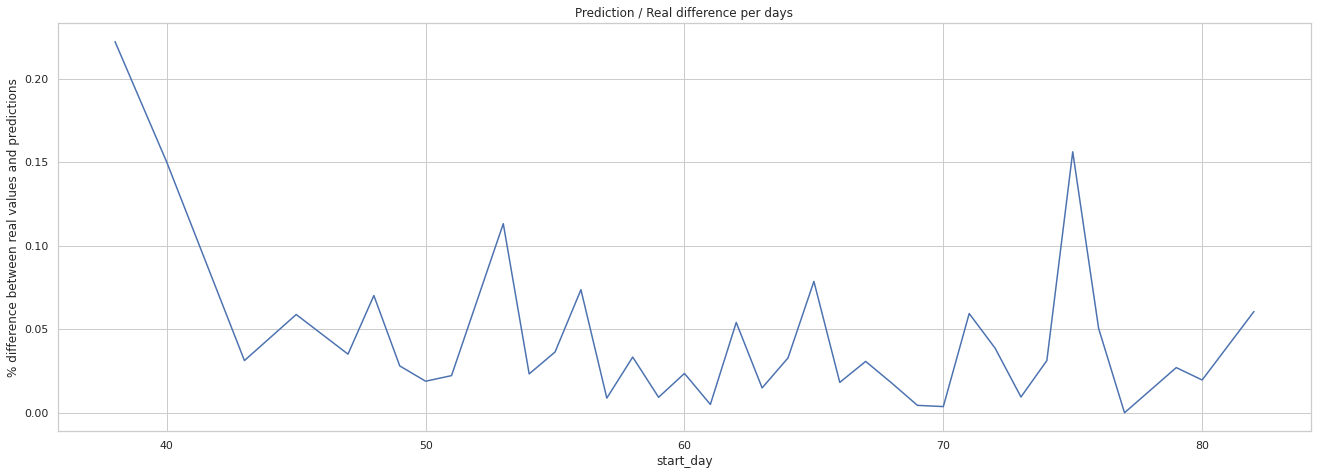

In [71]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["careplan_duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

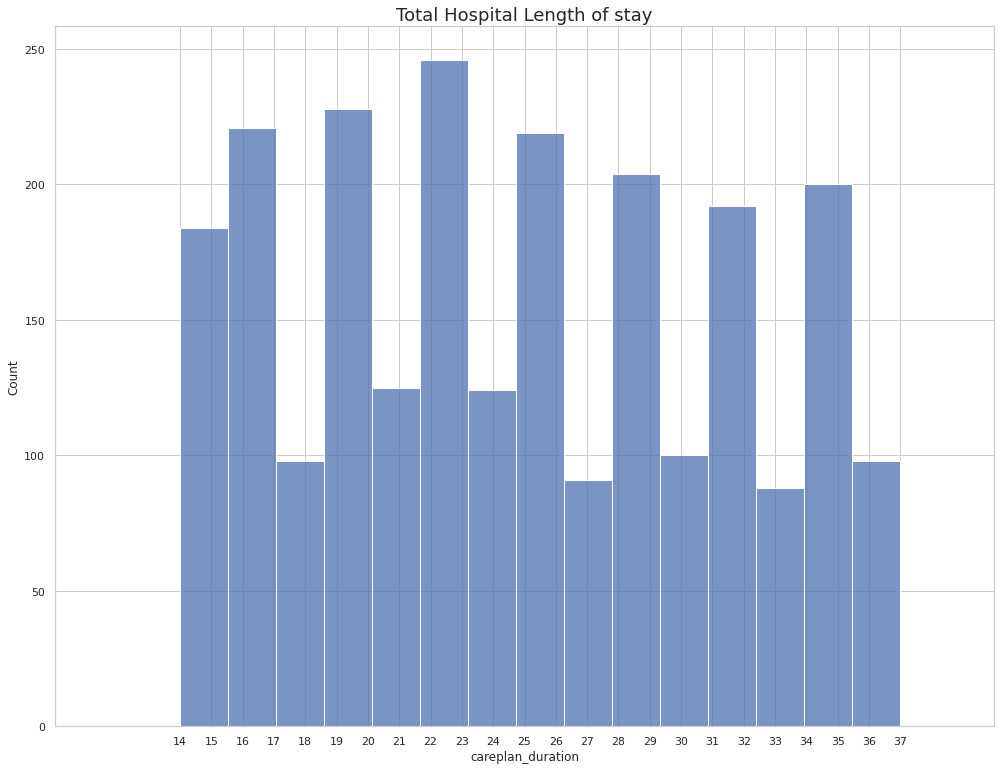

In [72]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "careplan_duration")
plt.xticks(np.arange(14,38,1))
plt.xlim(10,40)
plt.title('Total Hospital Length of stay', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

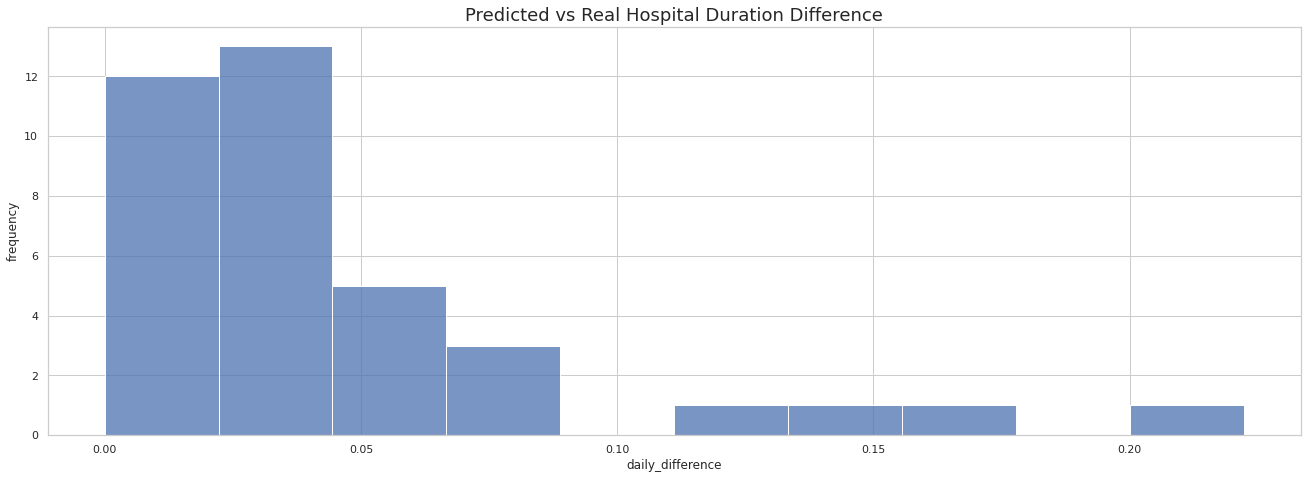

In [73]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real Hospital Duration Difference", fontsize = 18)
plt.ylabel("frequency")

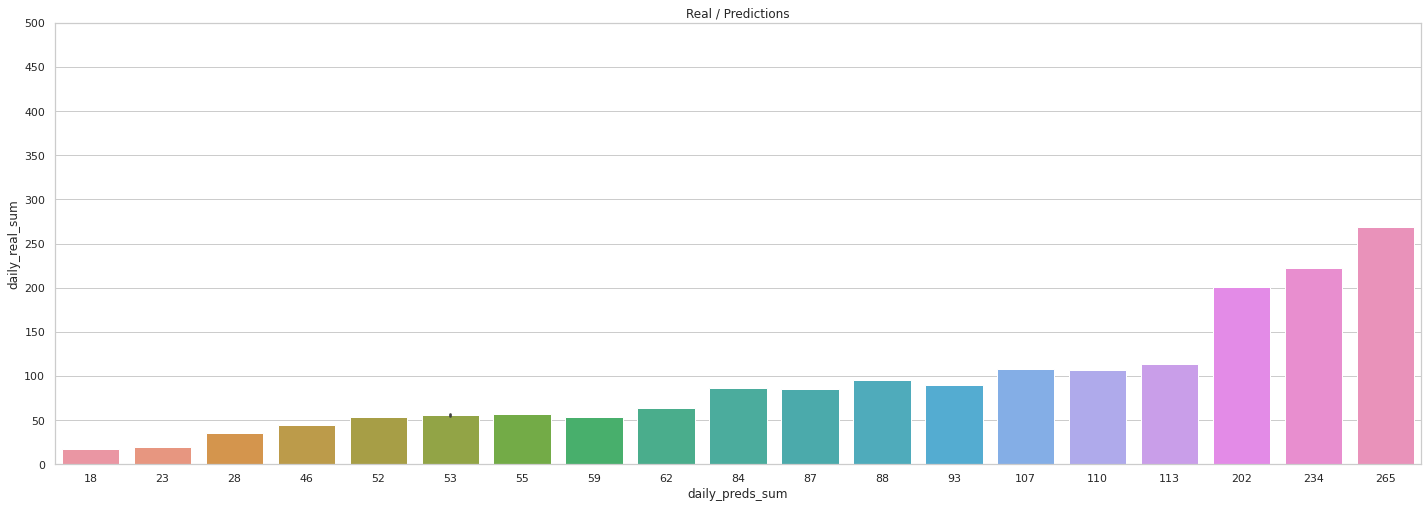

In [74]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

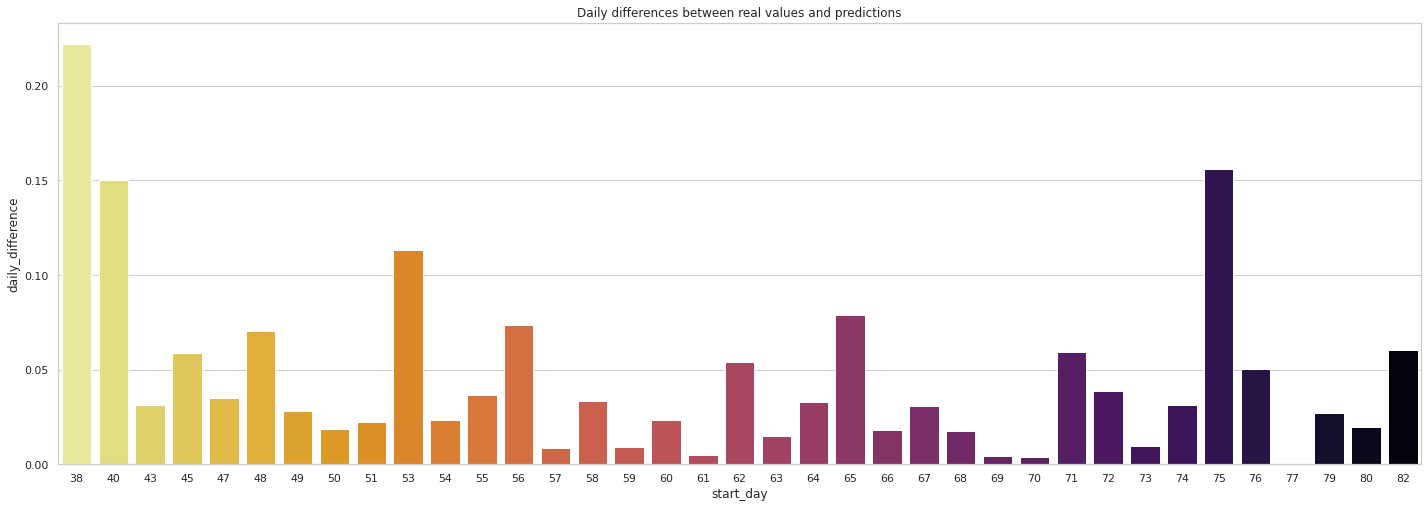

In [75]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [76]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [77]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [80]:
data = df.copy()
data = data.rename(columns = {"careplan_duration" : "duration"})
data = data.loc[data.duration > 0].reset_index(drop = True)

In [81]:
y = data['duration']
LABEL = "duration"

In [82]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [83]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [84]:
NUMERIC_FEATURES


['patient_condition_days_avg',
 'patient_condition_days_sum',
 'total_med_cost_of_patient',
 'healthcare_coverage_ratio',
 'age',
 'start_day',
 'total_med_duration_of_patient',
 'patient_condition_count',
 'total_med_count_of_patient',
 "patient's_condition_of_Viral sinusitis disorder",
 'start_week',
 "patient's Digital Radiographycount",
 "patient's_condition_of_Pneumonia disorder",
 'total_unique_med_of_patient',
 'patient_condition_unique']

In [85]:
CATEGORICAL_FEATURES

["patient's most seen observation",
 "patient's most seen condition",
 "patient's most used medication",
 'CITY',
 'COUNTY']

In [86]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [87]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [88]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [89]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [90]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 50

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/50
4/4 [==============================] - 22s 602ms/step - loss: 614.2933 - output_loss: 614.2933 - output_rmse: 24.7849 - val_loss: 511.8767 - val_output_loss: 511.8767 - val_output_rmse: 22.6247
Epoch 2/50
4/4 [==============================] - 1s 113ms/step - loss: 498.2775 - output_loss: 498.2775 - output_rmse: 22.3221 - val_loss: 454.6636 - val_output_loss: 454.6636 - val_output_rmse: 21.3228
Epoch 3/50
4/4 [==============================] - 0s 78ms/step - loss: 450.8425 - output_loss: 450.8425 - output_rmse: 21.2331 - val_loss: 432.9471 - val_output_loss: 432.9471 - val_output_rmse: 20.8074
Epoch 4/50
4/4 [==============================] - 0s 59ms/step - loss: 425.8463 - output_loss: 425.8463 - output_rmse: 20.6360 - val_loss: 419.4950 - val_output_loss: 419.4950 - val_output_rmse: 20.4816
Epoch 5/50
4/4 [==============================] - 0s 57ms/step - loss: 408.9325 - output_loss: 408.9325 - output_rmse: 20.2221 - val_loss: 405.9530 - val_output_loss: 405.9530 - val_out

In [91]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 50

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/50
4/4 [==============================] - 6s 266ms/step - loss: 597.7809 - output_loss: 597.7809 - output_rmse: 24.4496 - val_loss: 534.0527 - val_output_loss: 534.0527 - val_output_rmse: 23.1096
Epoch 2/50
4/4 [==============================] - 0s 46ms/step - loss: 530.0072 - output_loss: 530.0072 - output_rmse: 23.0219 - val_loss: 493.3091 - val_output_loss: 493.3091 - val_output_rmse: 22.2106
Epoch 3/50
4/4 [==============================] - 0s 44ms/step - loss: 488.2538 - output_loss: 488.2538 - output_rmse: 22.0965 - val_loss: 462.9600 - val_output_loss: 462.9600 - val_output_rmse: 21.5165
Epoch 4/50
4/4 [==============================] - 0s 44ms/step - loss: 459.7805 - output_loss: 459.7805 - output_rmse: 21.4425 - val_loss: 444.8275 - val_output_loss: 444.8275 - val_output_rmse: 21.0909
Epoch 5/50
4/4 [==============================] - 0s 46ms/step - loss: 439.4795 - output_loss: 439.4795 - output_rmse: 20.9638 - val_loss: 431.4129 - val_output_loss: 431.4129 - val_outpu

In [92]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 598ms/step


In [93]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.6 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [94]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 50

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-29 00:14:29,847] A new study created in memory with name: no-name-abbcf232-a2ab-422f-b203-2e746bc2fecf


Epoch 1/50
4/4 [==============================] - 12s 627ms/step - loss: 578.3508 - output_loss: 578.3508 - output_rmse: 24.0489 - val_loss: 467.8355 - val_output_loss: 467.8355 - val_output_rmse: 21.6295
Epoch 2/50
4/4 [==============================] - 0s 124ms/step - loss: 457.5871 - output_loss: 457.5871 - output_rmse: 21.3913 - val_loss: 403.1142 - val_output_loss: 403.1142 - val_output_rmse: 20.0777
Epoch 3/50
4/4 [==============================] - 0s 94ms/step - loss: 397.0403 - output_loss: 397.0403 - output_rmse: 19.9259 - val_loss: 366.0016 - val_output_loss: 366.0016 - val_output_rmse: 19.1312
Epoch 4/50
4/4 [==============================] - 0s 117ms/step - loss: 358.2712 - output_loss: 358.2712 - output_rmse: 18.9281 - val_loss: 342.7390 - val_output_loss: 342.7390 - val_output_rmse: 18.5132
Epoch 5/50
4/4 [==============================] - 0s 111ms/step - loss: 331.6512 - output_loss: 331.6512 - output_rmse: 18.2113 - val_loss: 322.0713 - val_output_loss: 322.0713 - val_o

[I 2023-01-29 00:15:04,949] Trial 0 finished with value: 6.6976954534716535 and parameters: {'numerical_bins': 147, 'embedding_dim': 42, 'depth': 4, 'heads': 8, 'attn_dropout': 0.2519341275656517, 'ff_dropout': 0.37757762302907644}. Best is trial 0 with value: 6.6976954534716535.


Epoch 1/50
4/4 [==============================] - 6s 292ms/step - loss: 514.1984 - output_loss: 514.1984 - output_rmse: 22.6759 - val_loss: 272.5321 - val_output_loss: 272.5321 - val_output_rmse: 16.5085
Epoch 2/50
4/4 [==============================] - 0s 65ms/step - loss: 298.5830 - output_loss: 298.5830 - output_rmse: 17.2796 - val_loss: 191.9299 - val_output_loss: 191.9299 - val_output_rmse: 13.8539
Epoch 3/50
4/4 [==============================] - 0s 62ms/step - loss: 196.3585 - output_loss: 196.3585 - output_rmse: 14.0128 - val_loss: 162.5529 - val_output_loss: 162.5529 - val_output_rmse: 12.7496
Epoch 4/50
4/4 [==============================] - 0s 55ms/step - loss: 154.7946 - output_loss: 154.7946 - output_rmse: 12.4416 - val_loss: 138.3074 - val_output_loss: 138.3074 - val_output_rmse: 11.7604
Epoch 5/50
4/4 [==============================] - 0s 56ms/step - loss: 128.3206 - output_loss: 128.3206 - output_rmse: 11.3279 - val_loss: 118.2195 - val_output_loss: 118.2195 - val_outpu

[I 2023-01-29 00:15:25,409] Trial 1 finished with value: 3.4096967912478005 and parameters: {'numerical_bins': 160, 'embedding_dim': 64, 'depth': 3, 'heads': 6, 'attn_dropout': 0.02433163048491993, 'ff_dropout': 0.438811348298333}. Best is trial 1 with value: 3.4096967912478005.


Epoch 1/50
4/4 [==============================] - 7s 344ms/step - loss: 561.9150 - output_loss: 561.9150 - output_rmse: 23.7047 - val_loss: 412.1045 - val_output_loss: 412.1045 - val_output_rmse: 20.3004
Epoch 2/50
4/4 [==============================] - 0s 70ms/step - loss: 406.3614 - output_loss: 406.3614 - output_rmse: 20.1584 - val_loss: 338.0824 - val_output_loss: 338.0824 - val_output_rmse: 18.3870
Epoch 3/50
4/4 [==============================] - 0s 69ms/step - loss: 331.3220 - output_loss: 331.3220 - output_rmse: 18.2023 - val_loss: 304.1031 - val_output_loss: 304.1031 - val_output_rmse: 17.4386
Epoch 4/50
4/4 [==============================] - 0s 68ms/step - loss: 294.2333 - output_loss: 294.2333 - output_rmse: 17.1532 - val_loss: 283.7167 - val_output_loss: 283.7167 - val_output_rmse: 16.8439
Epoch 5/50
4/4 [==============================] - 0s 70ms/step - loss: 270.7624 - output_loss: 270.7624 - output_rmse: 16.4549 - val_loss: 263.9041 - val_output_loss: 263.9041 - val_outpu

1/1 [==============================] - 1s 752ms/step


[I 2023-01-29 00:15:47,940] Trial 2 finished with value: 6.695665599895425 and parameters: {'numerical_bins': 200, 'embedding_dim': 66, 'depth': 4, 'heads': 5, 'attn_dropout': 0.20993316331450468, 'ff_dropout': 0.34530758839476083}. Best is trial 1 with value: 3.4096967912478005.


Epoch 1/50
4/4 [==============================] - 7s 313ms/step - loss: 612.8002 - output_loss: 612.8002 - output_rmse: 24.7548 - val_loss: 572.6365 - val_output_loss: 572.6365 - val_output_rmse: 23.9298
Epoch 2/50
4/4 [==============================] - 0s 50ms/step - loss: 572.2560 - output_loss: 572.2560 - output_rmse: 23.9219 - val_loss: 541.7987 - val_output_loss: 541.7987 - val_output_rmse: 23.2766
Epoch 3/50
4/4 [==============================] - 0s 50ms/step - loss: 544.2514 - output_loss: 544.2514 - output_rmse: 23.3292 - val_loss: 523.3630 - val_output_loss: 523.3630 - val_output_rmse: 22.8771
Epoch 4/50
4/4 [==============================] - 0s 50ms/step - loss: 522.5170 - output_loss: 522.5170 - output_rmse: 22.8586 - val_loss: 507.4790 - val_output_loss: 507.4790 - val_output_rmse: 22.5273
Epoch 5/50
4/4 [==============================] - 0s 46ms/step - loss: 503.3499 - output_loss: 503.3499 - output_rmse: 22.4355 - val_loss: 493.0953 - val_output_loss: 493.0953 - val_outpu

1/1 [==============================] - 1s 1s/step


[I 2023-01-29 00:16:09,424] Trial 3 finished with value: 7.545037000952241 and parameters: {'numerical_bins': 112, 'embedding_dim': 16, 'depth': 4, 'heads': 3, 'attn_dropout': 0.07153406562957176, 'ff_dropout': 0.32940639603325456}. Best is trial 1 with value: 3.4096967912478005.


Epoch 1/50
4/4 [==============================] - 6s 275ms/step - loss: 583.6281 - output_loss: 583.6281 - output_rmse: 24.1584 - val_loss: 511.5898 - val_output_loss: 511.5898 - val_output_rmse: 22.6184
Epoch 2/50
4/4 [==============================] - 0s 45ms/step - loss: 508.4196 - output_loss: 508.4196 - output_rmse: 22.5482 - val_loss: 468.7519 - val_output_loss: 468.7519 - val_output_rmse: 21.6507
Epoch 3/50
4/4 [==============================] - 0s 45ms/step - loss: 465.2336 - output_loss: 465.2336 - output_rmse: 21.5693 - val_loss: 437.0849 - val_output_loss: 437.0849 - val_output_rmse: 20.9066
Epoch 4/50
4/4 [==============================] - 0s 47ms/step - loss: 430.8528 - output_loss: 430.8528 - output_rmse: 20.7570 - val_loss: 409.6013 - val_output_loss: 409.6013 - val_output_rmse: 20.2386
Epoch 5/50
4/4 [==============================] - 0s 43ms/step - loss: 403.6318 - output_loss: 403.6318 - output_rmse: 20.0906 - val_loss: 388.5204 - val_output_loss: 388.5204 - val_outpu

[I 2023-01-29 00:16:27,920] Trial 4 finished with value: 6.714990335329388 and parameters: {'numerical_bins': 108, 'embedding_dim': 23, 'depth': 3, 'heads': 4, 'attn_dropout': 0.4603200955640234, 'ff_dropout': 0.27962339117004326}. Best is trial 1 with value: 3.4096967912478005.


Number of finished trials: 5
Best trial: {'numerical_bins': 160, 'embedding_dim': 64, 'depth': 3, 'heads': 6, 'attn_dropout': 0.02433163048491993, 'ff_dropout': 0.438811348298333}


In [95]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=160,
    embedding_dim=64,
    depth=3,
    heads=6,
    attn_dropout= 0.0243,
    ff_dropout= 0.4388,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
4/4 [==============================] - 6s 290ms/step - loss: 536.7202 - output_loss: 536.7202 - output_rmse: 23.1672 - val_loss: 383.1212 - val_output_loss: 383.1212 - val_output_rmse: 19.5735
Epoch 2/150
4/4 [==============================] - 0s 64ms/step - loss: 390.7541 - output_loss: 390.7541 - output_rmse: 19.7675 - val_loss: 317.9376 - val_output_loss: 317.9376 - val_output_rmse: 17.8308
Epoch 3/150
4/4 [==============================] - 0s 54ms/step - loss: 321.0205 - output_loss: 321.0205 - output_rmse: 17.9170 - val_loss: 290.8065 - val_output_loss: 290.8065 - val_output_rmse: 17.0530
Epoch 4/150
4/4 [==============================] - 0s 55ms/step - loss: 282.8456 - output_loss: 282.8456 - output_rmse: 16.8180 - val_loss: 268.8718 - val_output_loss: 268.8718 - val_output_rmse: 16.3973
Epoch 5/150
4/4 [==============================] - 0s 56ms/step - loss: 257.7106 - output_loss: 257.7106 - output_rmse: 16.0534 - val_loss: 249.4669 - val_output_loss: 249.4669 - val_

In [96]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 603ms/step


### Periodic Encoding FT Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

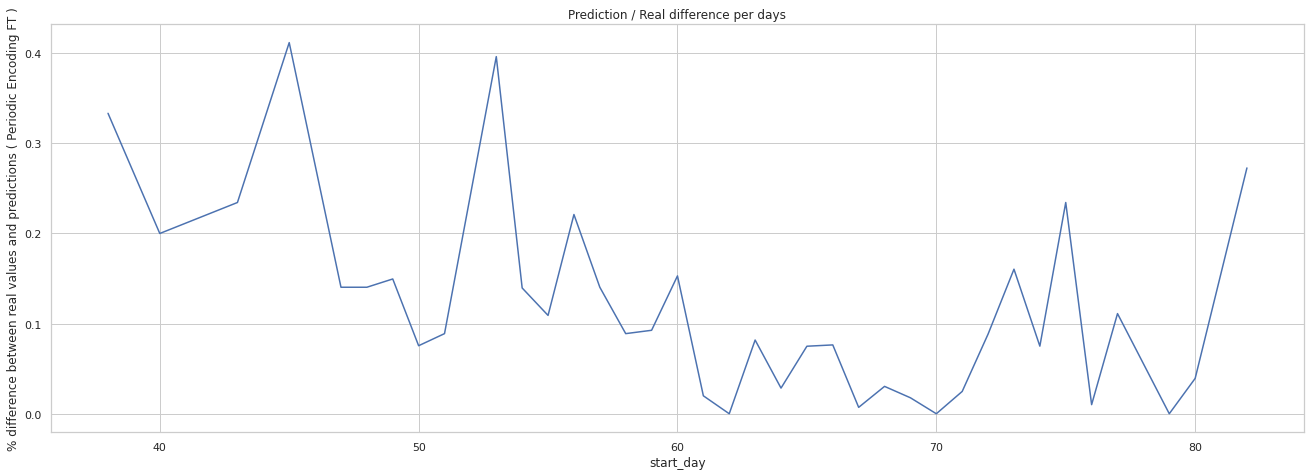

In [97]:
test_copy = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["careplan_duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

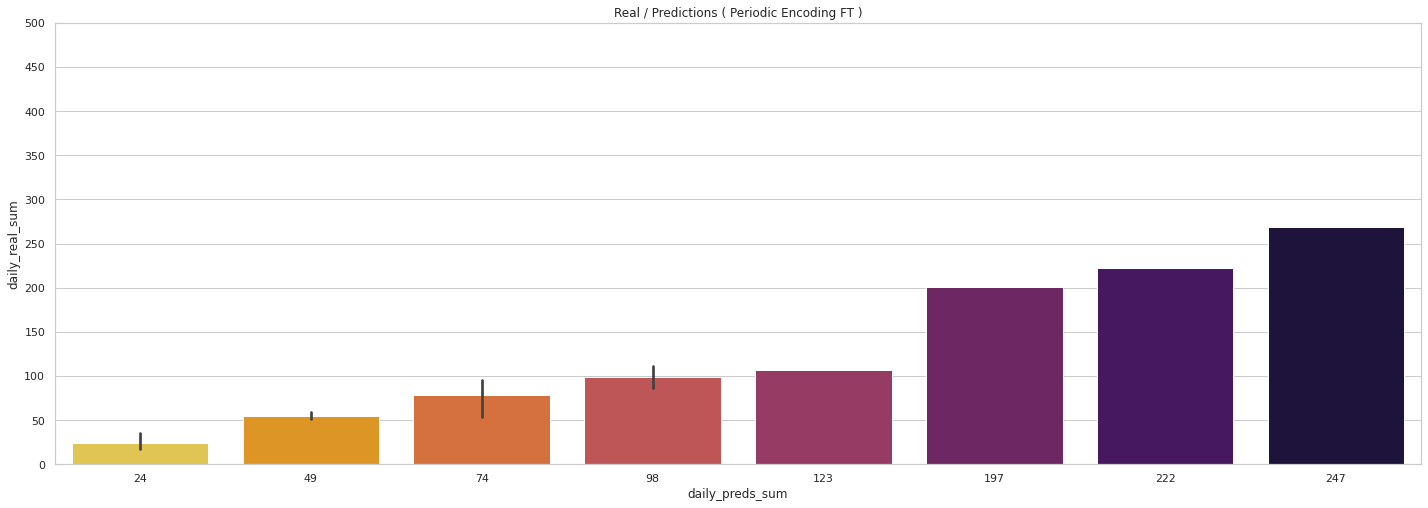

In [98]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

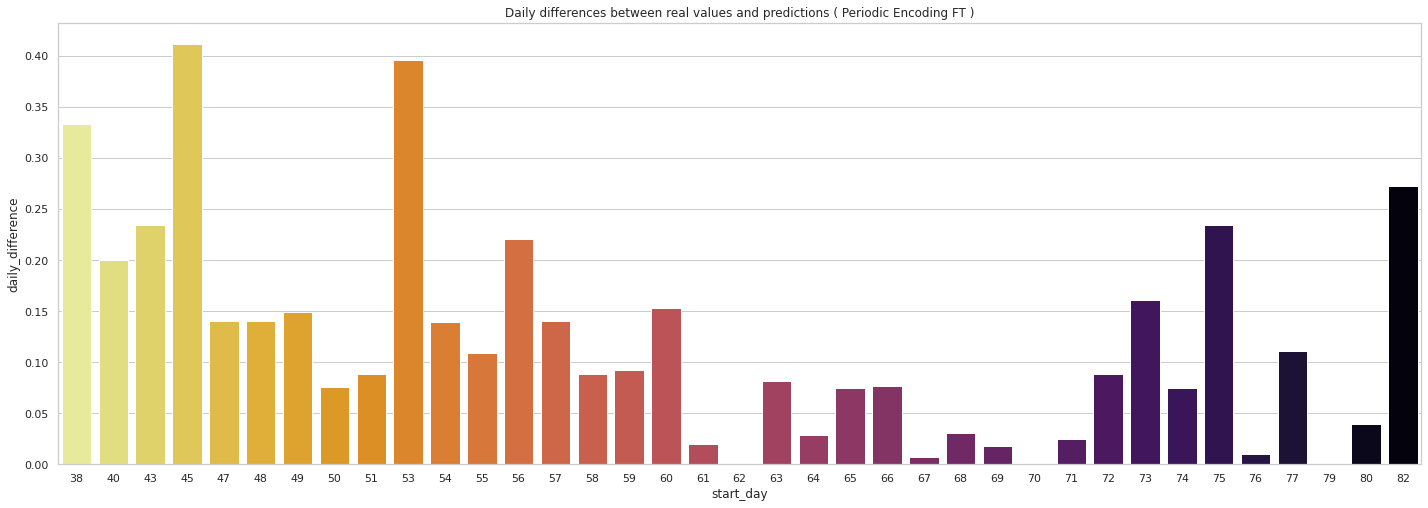

In [99]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [100]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 50

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-29 00:20:08,905] A new study created in memory with name: no-name-c0ba774d-96f8-47a6-9e6b-1a015d109a47


Epoch 1/50
4/4 [==============================] - 12s 423ms/step - loss: 624.7187 - output_loss: 624.7187 - output_rmse: 24.9944 - val_loss: 568.4609 - val_output_loss: 568.4609 - val_output_rmse: 23.8424
Epoch 2/50
4/4 [==============================] - 0s 70ms/step - loss: 566.9063 - output_loss: 566.9063 - output_rmse: 23.8098 - val_loss: 536.7516 - val_output_loss: 536.7516 - val_output_rmse: 23.1679
Epoch 3/50
4/4 [==============================] - 0s 62ms/step - loss: 531.5344 - output_loss: 531.5344 - output_rmse: 23.0550 - val_loss: 521.4725 - val_output_loss: 521.4725 - val_output_rmse: 22.8358
Epoch 4/50
4/4 [==============================] - 0s 61ms/step - loss: 512.6106 - output_loss: 512.6106 - output_rmse: 22.6409 - val_loss: 508.9327 - val_output_loss: 508.9327 - val_output_rmse: 22.5595
Epoch 5/50
4/4 [==============================] - 0s 57ms/step - loss: 499.0979 - output_loss: 499.0979 - output_rmse: 22.3405 - val_loss: 499.3987 - val_output_loss: 499.3987 - val_outp

[I 2023-01-29 00:20:37,197] Trial 0 finished with value: 11.033242136104684 and parameters: {'numerical_bins': 166, 'embedding_dim': 9, 'depth': 6, 'heads': 4, 'attn_dropout': 0.05633825109552182, 'ff_dropout': 0.4381046592067502}. Best is trial 0 with value: 11.033242136104684.


Epoch 1/50
4/4 [==============================] - 5s 282ms/step - loss: 500.6420 - output_loss: 500.6420 - output_rmse: 22.3750 - val_loss: 299.5868 - val_output_loss: 299.5868 - val_output_rmse: 17.3086
Epoch 2/50
4/4 [==============================] - 0s 55ms/step - loss: 279.2561 - output_loss: 279.2561 - output_rmse: 16.7110 - val_loss: 218.4120 - val_output_loss: 218.4120 - val_output_rmse: 14.7788
Epoch 3/50
4/4 [==============================] - 0s 54ms/step - loss: 210.2130 - output_loss: 210.2130 - output_rmse: 14.4987 - val_loss: 188.4503 - val_output_loss: 188.4503 - val_output_rmse: 13.7277
Epoch 4/50
4/4 [==============================] - 0s 54ms/step - loss: 179.5776 - output_loss: 179.5776 - output_rmse: 13.4007 - val_loss: 166.4424 - val_output_loss: 166.4424 - val_output_rmse: 12.9013
Epoch 5/50
4/4 [==============================] - 0s 50ms/step - loss: 156.4844 - output_loss: 156.4844 - output_rmse: 12.5094 - val_loss: 146.2533 - val_output_loss: 146.2533 - val_outpu

[I 2023-01-29 00:20:54,029] Trial 1 finished with value: 6.681204416121503 and parameters: {'numerical_bins': 135, 'embedding_dim': 79, 'depth': 3, 'heads': 3, 'attn_dropout': 0.4783124854146317, 'ff_dropout': 0.2557757943010889}. Best is trial 1 with value: 6.681204416121503.


Epoch 1/50
4/4 [==============================] - 7s 331ms/step - loss: 469.9820 - output_loss: 469.9820 - output_rmse: 21.6791 - val_loss: 254.4650 - val_output_loss: 254.4650 - val_output_rmse: 15.9520
Epoch 2/50
4/4 [==============================] - 0s 65ms/step - loss: 247.4795 - output_loss: 247.4795 - output_rmse: 15.7315 - val_loss: 169.4482 - val_output_loss: 169.4482 - val_output_rmse: 13.0172
Epoch 3/50
4/4 [==============================] - 0s 60ms/step - loss: 168.7961 - output_loss: 168.7961 - output_rmse: 12.9922 - val_loss: 137.1636 - val_output_loss: 137.1636 - val_output_rmse: 11.7117
Epoch 4/50
4/4 [==============================] - 0s 54ms/step - loss: 131.8042 - output_loss: 131.8042 - output_rmse: 11.4806 - val_loss: 114.0613 - val_output_loss: 114.0613 - val_output_rmse: 10.6800
Epoch 5/50
4/4 [==============================] - 0s 56ms/step - loss: 107.1934 - output_loss: 107.1934 - output_rmse: 10.3534 - val_loss: 95.3017 - val_output_loss: 95.3017 - val_output_

[I 2023-01-29 00:21:14,246] Trial 2 finished with value: 5.354579315066233 and parameters: {'numerical_bins': 134, 'embedding_dim': 74, 'depth': 4, 'heads': 2, 'attn_dropout': 0.17700991030572932, 'ff_dropout': 0.34184376119321985}. Best is trial 2 with value: 5.354579315066233.


Epoch 1/50
4/4 [==============================] - 9s 427ms/step - loss: 537.6254 - output_loss: 537.6254 - output_rmse: 23.1867 - val_loss: 385.5907 - val_output_loss: 385.5907 - val_output_rmse: 19.6365
Epoch 2/50
4/4 [==============================] - 0s 80ms/step - loss: 377.5707 - output_loss: 377.5707 - output_rmse: 19.4312 - val_loss: 318.1706 - val_output_loss: 318.1706 - val_output_rmse: 17.8373
Epoch 3/50
4/4 [==============================] - 0s 69ms/step - loss: 313.9671 - output_loss: 313.9671 - output_rmse: 17.7191 - val_loss: 287.8757 - val_output_loss: 287.8757 - val_output_rmse: 16.9669
Epoch 4/50
4/4 [==============================] - 0s 70ms/step - loss: 281.7157 - output_loss: 281.7157 - output_rmse: 16.7844 - val_loss: 267.2647 - val_output_loss: 267.2647 - val_output_rmse: 16.3482
Epoch 5/50
4/4 [==============================] - 0s 69ms/step - loss: 258.3643 - output_loss: 258.3643 - output_rmse: 16.0737 - val_loss: 248.4033 - val_output_loss: 248.4033 - val_outpu

[I 2023-01-29 00:21:40,311] Trial 3 finished with value: 6.691296238596778 and parameters: {'numerical_bins': 90, 'embedding_dim': 37, 'depth': 6, 'heads': 4, 'attn_dropout': 0.39271948735701634, 'ff_dropout': 0.36002894029923455}. Best is trial 2 with value: 5.354579315066233.


Epoch 1/50
4/4 [==============================] - 3s 155ms/step - loss: 625.1057 - output_loss: 625.1057 - output_rmse: 25.0021 - val_loss: 575.8628 - val_output_loss: 575.8628 - val_output_rmse: 23.9971
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 569.5398 - output_loss: 569.5398 - output_rmse: 23.8650 - val_loss: 544.5883 - val_output_loss: 544.5883 - val_output_rmse: 23.3364
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: 546.2674 - output_loss: 546.2674 - output_rmse: 23.3724 - val_loss: 523.0366 - val_output_loss: 523.0366 - val_output_rmse: 22.8700
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - loss: 525.5341 - output_loss: 525.5341 - output_rmse: 22.9245 - val_loss: 497.9768 - val_output_loss: 497.9768 - val_output_rmse: 22.3154
Epoch 5/50
4/4 [==============================] - 0s 26ms/step - loss: 505.1175 - output_loss: 505.1175 - output_rmse: 22.4748 - val_loss: 476.0419 - val_output_loss: 476.0419 - val_outpu

[I 2023-01-29 00:21:50,969] Trial 4 finished with value: 6.771583501585741 and parameters: {'numerical_bins': 152, 'embedding_dim': 18, 'depth': 1, 'heads': 5, 'attn_dropout': 0.42589264348865513, 'ff_dropout': 0.21151416699399717}. Best is trial 2 with value: 5.354579315066233.


Number of finished trials: 5
Best trial: {'numerical_bins': 134, 'embedding_dim': 74, 'depth': 4, 'heads': 2, 'attn_dropout': 0.17700991030572932, 'ff_dropout': 0.34184376119321985}


In [102]:
study.best_trial.params

{'numerical_bins': 134,
 'embedding_dim': 74,
 'depth': 4,
 'heads': 2,
 'attn_dropout': 0.17700991030572932,
 'ff_dropout': 0.34184376119321985}

In [103]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=134,
    embedding_dim=74,
    depth=4,
    heads=2,
    attn_dropout= 0.1770,
    ff_dropout= 0.3418,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 30

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/30
4/4 [==============================] - 7s 317ms/step - loss: 426.3651 - output_loss: 426.3651 - output_rmse: 20.6486 - val_loss: 204.8256 - val_output_loss: 204.8256 - val_output_rmse: 14.3117
Epoch 2/30
4/4 [==============================] - 0s 54ms/step - loss: 200.6570 - output_loss: 200.6570 - output_rmse: 14.1653 - val_loss: 132.1023 - val_output_loss: 132.1023 - val_output_rmse: 11.4936
Epoch 3/30
4/4 [==============================] - 0s 50ms/step - loss: 130.8375 - output_loss: 130.8375 - output_rmse: 11.4384 - val_loss: 101.1321 - val_output_loss: 101.1321 - val_output_rmse: 10.0564
Epoch 4/30
4/4 [==============================] - 0s 53ms/step - loss: 97.7027 - output_loss: 97.7027 - output_rmse: 9.8845 - val_loss: 81.7348 - val_output_loss: 81.7348 - val_output_rmse: 9.0407
Epoch 5/30
4/4 [==============================] - 0s 51ms/step - loss: 77.2110 - output_loss: 77.2110 - output_rmse: 8.7870 - val_loss: 67.7527 - val_output_loss: 67.7527 - val_output_rmse: 8.2

In [104]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 727ms/step


In [105]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 17ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

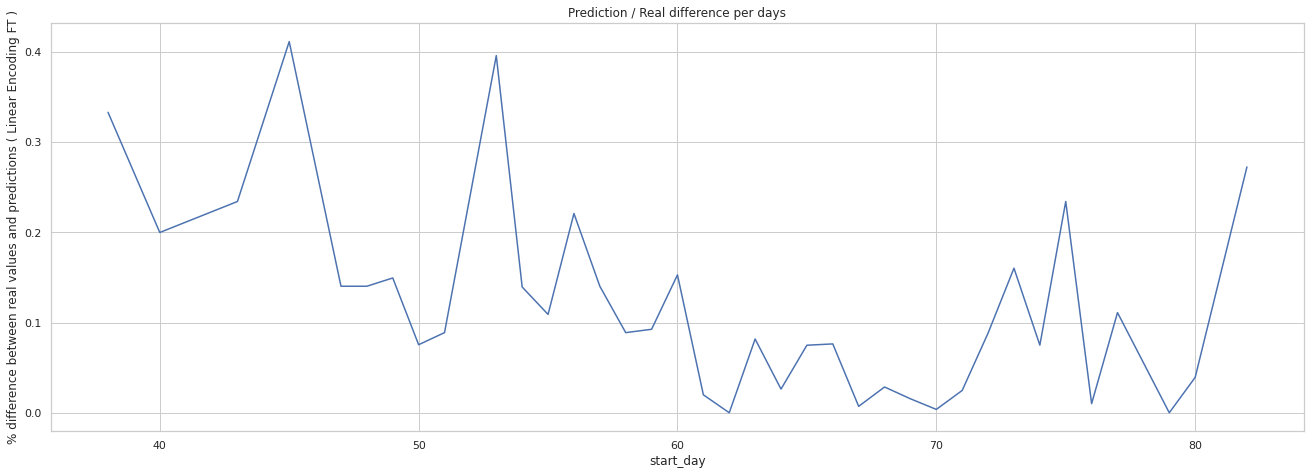

In [106]:
test_copy = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["careplan_duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

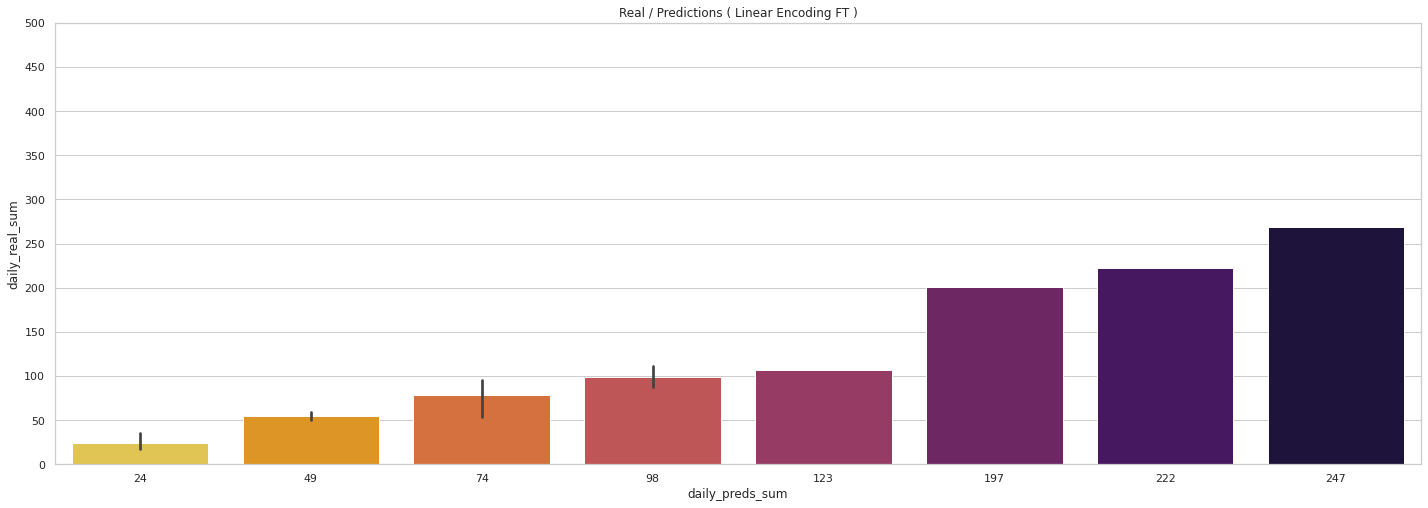

In [107]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

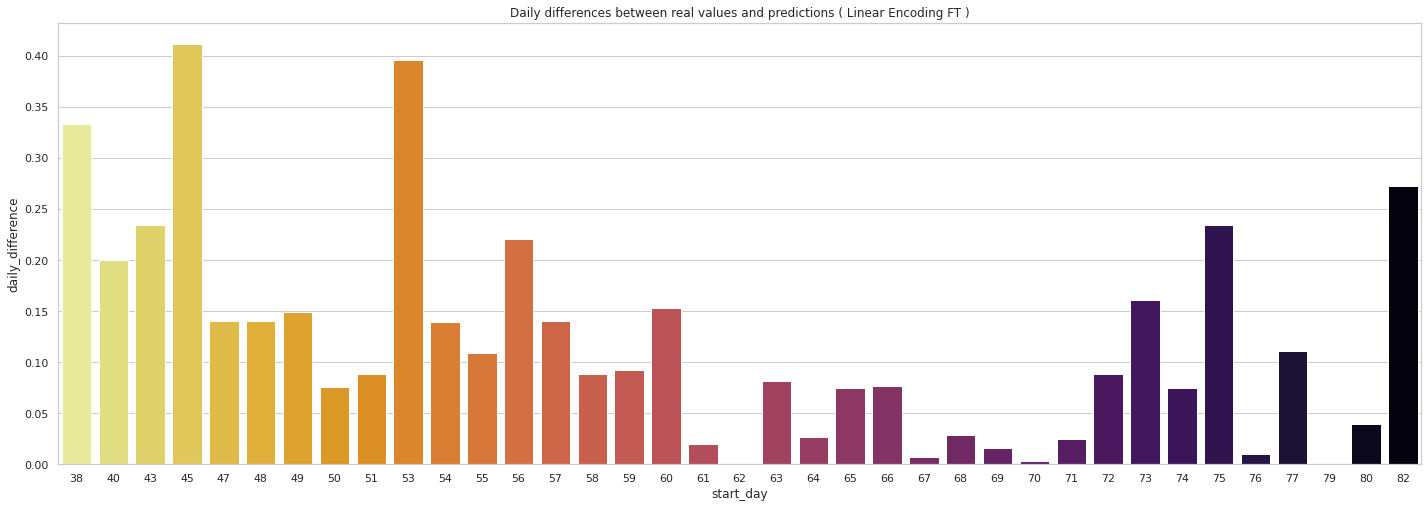

In [108]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [109]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.029170,5.844356,6.772993
Transformer - Periodic Encoding,-0.029170,6.027810,7.100124
LightGBM,0.859874,1.463122,2.499170


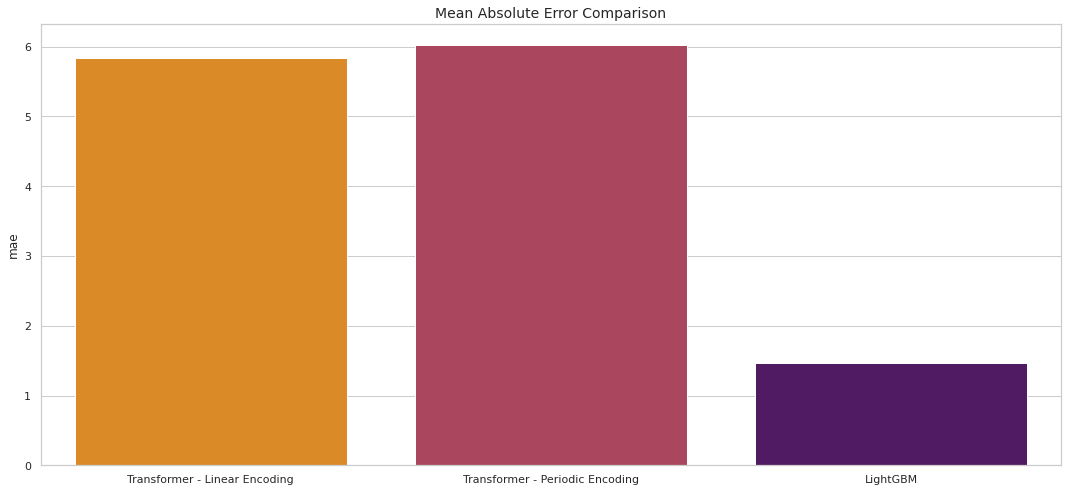

In [110]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


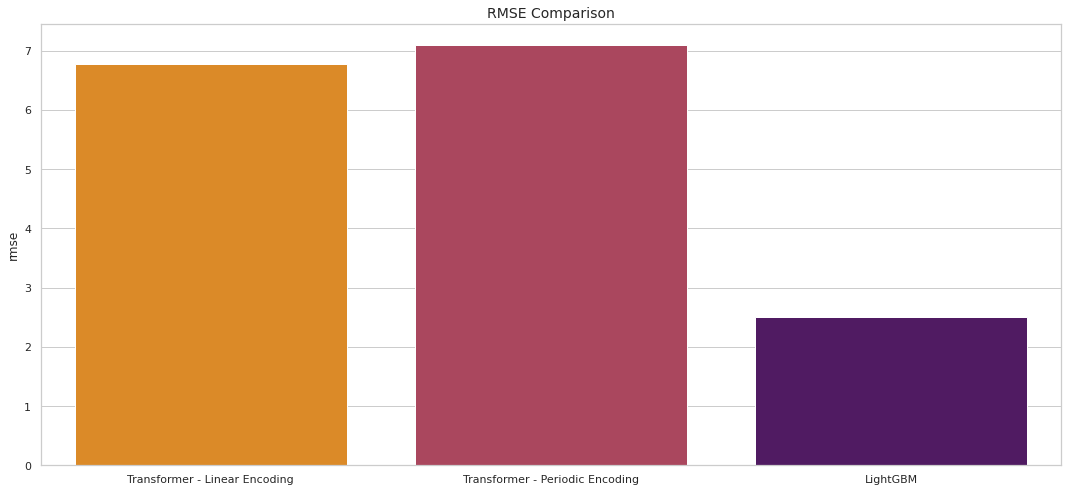

In [111]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


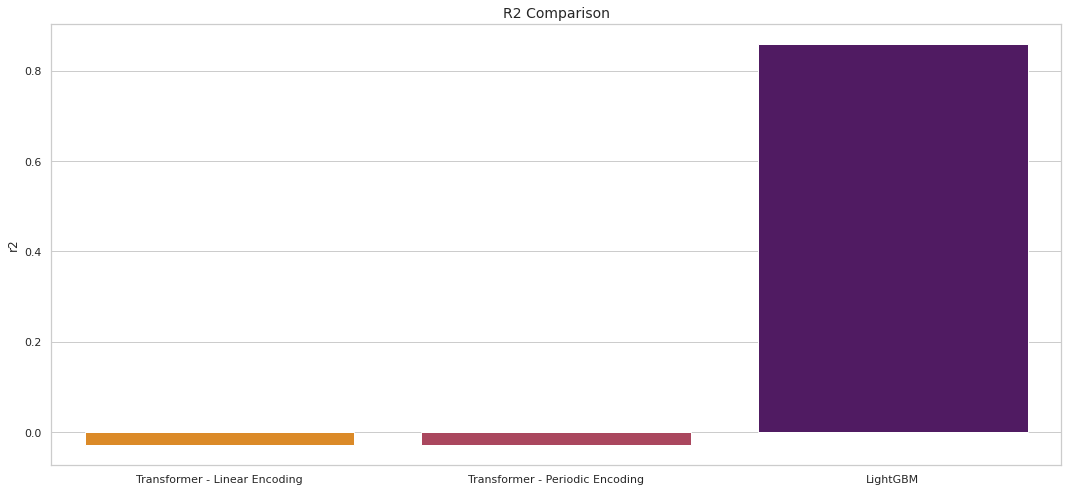

In [112]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [113]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"])
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.000080,5.800433,6.676585
Transformer - Periodic Encoding TUNED,-0.004459,5.812759,6.691186
LightGBM TUNED,0.863179,1.544426,2.469526


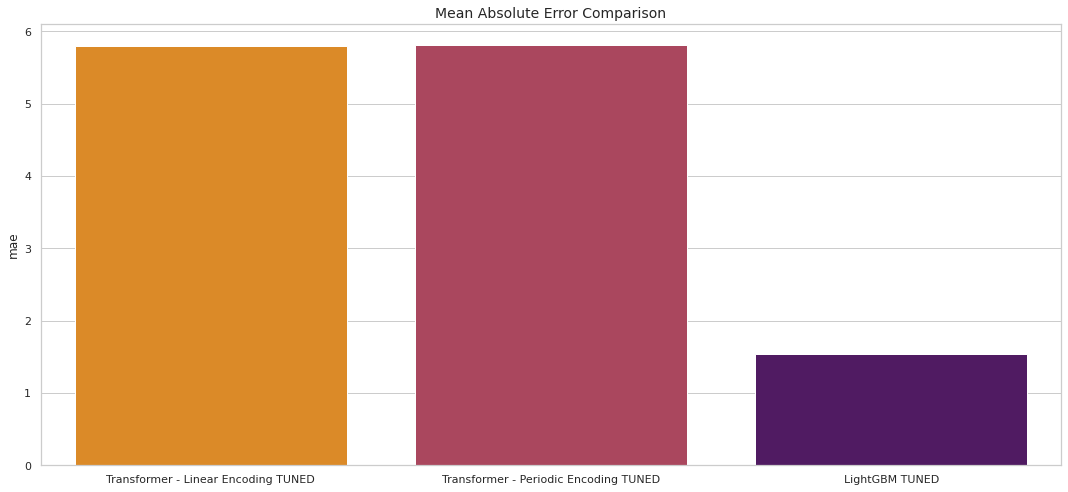

In [114]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


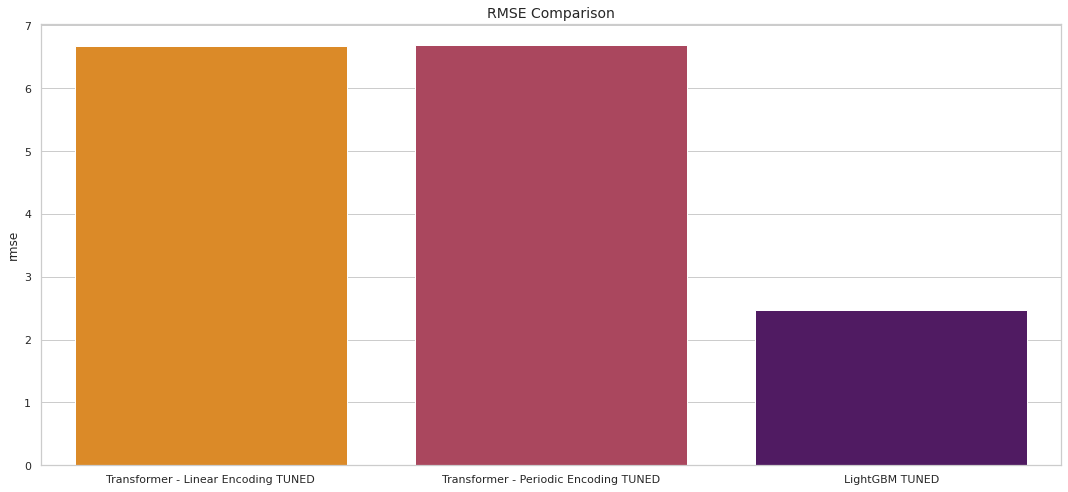

In [115]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


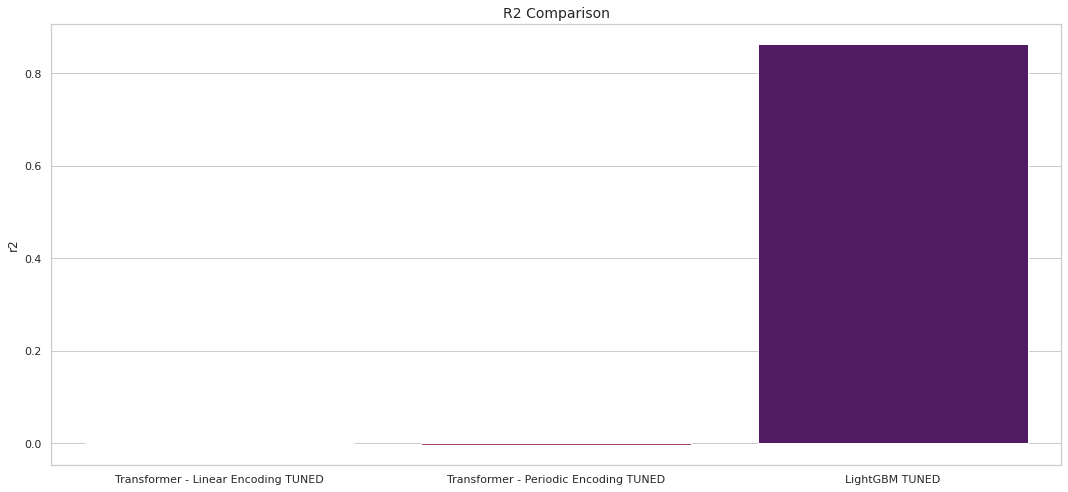

In [116]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
